In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
def load_data(path, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Pad(223, padding_mode='reflect'),
        transforms.RandomAffine(degrees=15, shear=45),
        transforms.CenterCrop(224)
    ])

    dataset = ImageFolder(path, transform=transform)

    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

    print("📃 Train Dataset Information:")
    class_counts_train = {cls: 0 for cls in class_names}
    for _, label in train_dataset:
        class_name = dataset.classes[label]
        class_counts_train[class_name] += 1

    for cls_name, count in class_counts_train.items():
        print(f"\tNumber of images in class {cls_name}: {count}")
    print(f"\tTotal number of training samples: {len(train_dataset)}")

    print("\n📃 Validation Dataset Information:")
    class_counts_val = {cls: 0 for cls in class_names}
    for _, label in val_dataset:
        class_name = dataset.classes[label]
        class_counts_val[class_name] += 1

    for cls_name, count in class_counts_val.items():
        print(f"\tNumber of images in class {cls_name}: {count}")
    print(f"\tTotal number of validation samples: {len(val_dataset)}")

    print("\n📃 Test Dataset Information:")
    class_counts_test = {cls: 0 for cls in class_names}
    for _, label in test_dataset:
        class_name = dataset.classes[label]
        class_counts_test[class_name] += 1

    for cls_name, count in class_counts_test.items():
        print(f"\tNumber of images in class {cls_name}: {count}")
    print(f"\tTotal number of test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

In [18]:
def imshow_grid(batch, labels):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        image = batch[i].permute(1, 2, 0).numpy()
        label = labels[i]

        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.set_title(f"{label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

📃 Train Dataset Information:
	Number of images in class Foodwaste: 1430
	Number of images in class Glass: 1003
	Number of images in class Metal: 1368
	Number of images in class Papers: 2140
	Number of images in class Plastic: 3875
	Number of images in class Textile: 684
	Total number of training samples: 10500

📃 Validation Dataset Information:
	Number of images in class Foodwaste: 270
	Number of images in class Glass: 250
	Number of images in class Metal: 334
	Number of images in class Papers: 427
	Number of images in class Plastic: 811
	Number of images in class Textile: 158
	Total number of validation samples: 2250

📃 Test Dataset Information:
	Number of images in class Foodwaste: 300
	Number of images in class Glass: 247
	Number of images in class Metal: 298
	Number of images in class Papers: 433
	Number of images in class Plastic: 814
	Number of images in class Textile: 158
	Total number of test samples: 2250


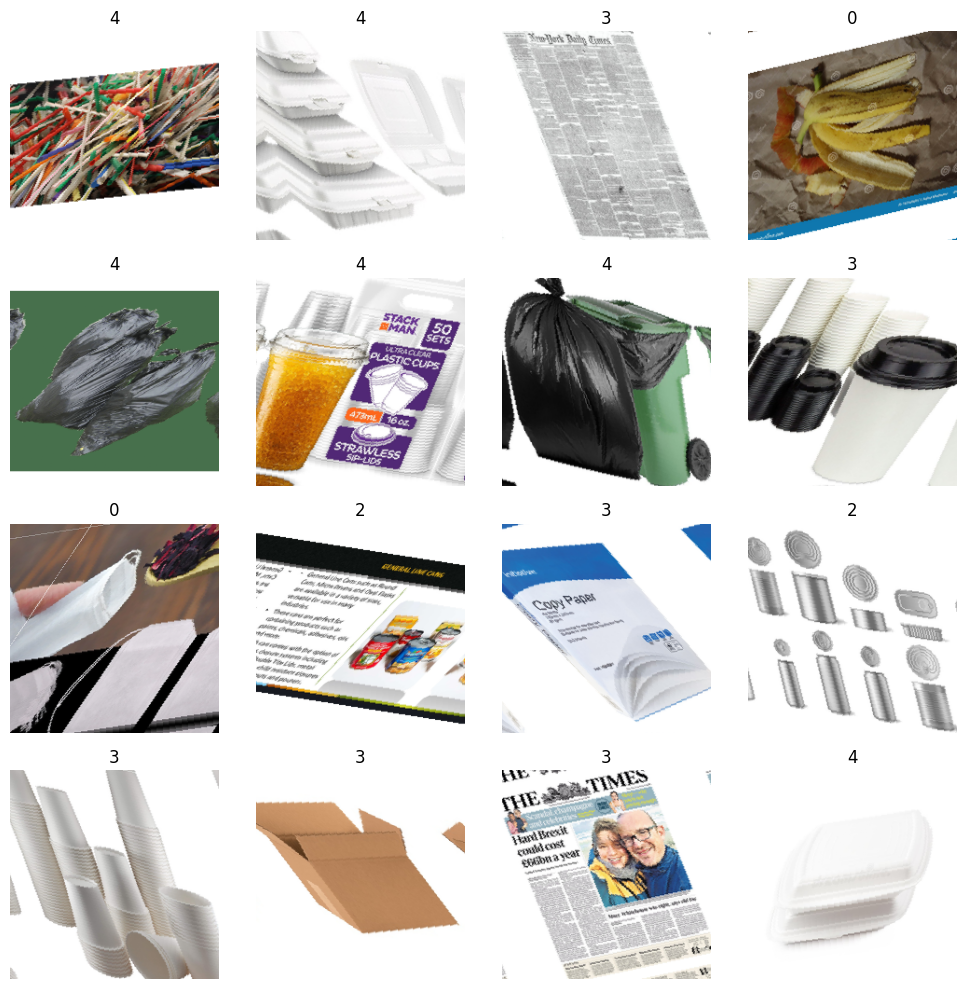

In [19]:
path = r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images'
class_names = [f'{name}' for name in os.listdir(path)]
train_loader, val_loader, test_loader = load_data(path, class_names)
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels)

In [23]:
class Resnet50(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, num_classes=6, input_size=(1, 224, 224), trainable_layers_idx=None):
        super(Resnet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_features = list(self.resnet50.children())[-1].in_features
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-1],
                                      nn.Flatten(),
                                      nn.Linear(num_features, 101)
                                      )

        
    
    def forward(self, x):
        x = self.resnet50(x)
        
        return x

In [11]:
class MobileNetV3(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, num_classes=6, input_size=(1, 224, 224), trainable_layers_idx=None):
        super(MobileNetV3, self).__init__()
        self.mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)

        #Freeze Feature Extractor Layers
        for param in self.mobilenet_v3.features[:].parameters():
            param.requires_grad = False

        #Unfreeze Classifier Layers
        for param in self.mobilenet_v3.classifier.parameters():
            param.requires_grad = True

        if trainable_layers_idx is not None:
            for idx in trainable_layers_idx:
                for param in self.mobilenet_v3.features[idx].parameters():
                    param.requires_grad = True

        if add_feat_dims:
            features = []
            for i, out_ch in enumerate(add_feat_dims):
                if i == 0:
                    features.append(nn.Conv2d(512, out_ch, kernel_size=3, padding=1))
                else:
                    features.append(nn.Conv2d(add_feat_dims[i-1], out_ch, kernel_size=3, padding=1))
                features.append(nn.ReLU())
            self.mobilenet_v3.features = nn.Sequential(self.mobilenet_v3.features, *features)

        input_size_fc1 = self._get_input_size_fc(input_size)

        if h_dims:
            layers = []
            for i, hdim in enumerate(h_dims):
                if i == 0:
                    layers.append(nn.Linear(input_size_fc1, hdim))
                else:
                    layers.append(nn.Linear(h_dims[i-1], hdim))
                layers.append(nn.Dropout(0.4))
                layers.append(nn.ReLU())
            self.mobilenet_v3.classifier = nn.Sequential(*layers, nn.Linear(h_dims[-1], num_classes))
        else:
            self.mobilenet_v3.classifier = nn.Linear(input_size_fc1, num_classes)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.mobilenet_v3.features(x)
            x = self.mobilenet_v3.avgpool(x)
            x = torch.flatten(x, 1)
            
            return x.size(1)
    
    def forward(self, x):
        x = self.mobilenet_v3.features(x)
        x = self.mobilenet_v3.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.mobilenet_v3.classifier(x)
        return x

In [27]:
def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cuda'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        correct_train = 0
        total_train = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            _,predicted = torch.max(outputs,1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        train_accuracy = 100 * correct_train/total_train
        
        model.eval()
        avg_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
            
        with torch.no_grad():
            for images, labels in val_bar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                val_loss = loss_fn(outputs, labels)

                avg_val_loss += val_loss.item()
                _,predicted = torch.max(outputs,1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val/total_val
    
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f},Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if writer:
            writer.add_scalar('Accuracy/Train', train_accuracy, epoch + 1)
            writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch + 1)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch + 1)

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")


def evaluate_task(y_true, y_pred, target_names="Task"):
    clf_report = classification_report(y_true, y_pred, target_names=target_names, zero_division=1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:\n", clf_report)

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()

In [22]:
model = models.resnet50()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model1 = Resnet50()


writer = SummaryWriter(log_dir='./runs/resnet_experiment')
opt = optim.Adam(model1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=model1, opt=opt, loss_fn=loss_fn, epochs=2, train_loader=train_loader, val_loader=val_loader, writer=writer, device='cuda', checkpoint_path="models/model1/model1")
writer.close()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validation: 100%|██████████| 141/141 [01:49<00:00,  1.28batch/s]


Epoch [1/2], Train Loss: 1.4435, Train Acc: 47.3238,Val Loss: 1.4332, Val Acc: 47.6000


🚀 Training Epoch [2/2]:  49%|████▉     | 322/657 [04:27<06:42,  1.20s/batch, loss=1.11] 